# Exploratory Data Analysis (EDA) and Modelling

EDA for fraud detection, these are the steps i took and their reasoning



1. Data Collection: Gather relevant data (data already given in the problem set)

2. Data Cleansing: Clean and preprocess the data by handling missing values, removing duplicates, and correcting errors or inconsistencies.

3. Data Exploration: Analyze the data to understand its characteristics, distributions, and relationships between variables. This can be done using descriptive statistics, histograms, box plots, scatter plots, and correlation matrices.

4. Feature Selection: Identify the most relevant features for detecting fraud using techniques like Recursive Feature Elimination (RFE), LASSO regression, or feature importance from tree-based models.

5. Class Imbalance: Address the class imbalance problem, common in fraud detection, by using techniques such as oversampling, undersampling, or synthetic data generation with methods like SMOTE.

6. Model Baseline: Establish a baseline model using simple algorithms (e.g., logistic regression) to set a performance benchmark for more advanced models. The models i test are:
- Logistic Regression (Baseline)
- LightGBM
- Simple ANN

7. Model Evaluation: Compare different machine learning models for this problem set i will use SVM and lightgbm

8. Iterative Process (if needed): continuously refine the data and models based on new insights or changing patterns in the data.

In [26]:
!pip install imbalanced-learn

In [27]:
# # If ran from Google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
CHOSEN_CONFIG = {
    "model" : "ann",
    "sampling" : "oversample", # IF OVERSAMPLE, MUST IMPUTE NAN
    "impute_nan" : True,
    "minmaxscale" : True
}

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import lightgbm as lgb

## Data Cleaning & Feature Engineering

In [30]:
# Change this if ran from Google Collab
train_id = pd.read_csv('datasets/ps-2/train_identity.csv')
train_tr = pd.read_csv('datasets/ps-2/train_transaction.csv')
test_id = pd.read_csv('datasets/ps-2/test_identity.csv')
test_tr = pd.read_csv('datasets/ps-2/test_transaction.csv')

train = pd.merge(train_tr, train_id, on='TransactionID', how='left')

del train_id
del train_tr

test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id
del test_tr


In [31]:
# Reduce memory usage, essentially if the value of the columns fall below a lower bitvalue than float64, its imputed to that type

def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [32]:
import gc
gc.collect()

2252

In [33]:
train = reduce_memory(train)
test = reduce_memory(test)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 530.06 MB
Decreased by 73.0%
Memory usage of dataframe is 1677.73 MB
Memory usage after optimization is: 462.06 MB
Decreased by 72.5%


In [34]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,...,139369.0,4.511300e+04,139318.0,139261.0,5159.0,5169.000000,4747.000000,5132.0000,5163.00000,77586.0
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,inf,inf,12.820312,inf,inf,NaN
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,...,0.0,1.561523e+00,NaN,NaN,inf,6.898438,2.373047,97.4375,32.09375,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,...,100.0,1.000000e+01,100.0,100.0,100.0,10.000000,11.000000,100.0000,100.00000,0.0
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,...,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,11.000000,321.0000,119.00000,24.0
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,...,166.0,1.500000e+01,341.0,472.0,252.0,14.000000,11.000000,321.0000,149.00000,24.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,...,225.0,1.500000e+01,427.0,533.0,486.5,14.000000,15.000000,371.0000,169.00000,32.0
max,3.577539e+06,1.000000,1.581113e+07,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,...,229.0,2.900000e+01,671.0,661.0,854.0,44.000000,26.000000,548.0000,216.00000,32.0


In [35]:
test.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id-17,id-18,id-19,id-20,id-21,id-22,id-24,id-25,id-26,id-32
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,498037.0,503689.0,502144.0,441082.0,441082.0,215474.0,...,135966.0,5.087500e+04,135906.0,135633.0,5059.0,5062.000000,4740.000000,5039.000,5047.00000,70671.0
mean,3.916894e+06,2.692994e+07,NaN,9957.222175,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,inf,inf,13.179688,inf,inf,NaN
std,1.462692e+05,4.756507e+06,NaN,4884.960969,NaN,0.0,0.0,NaN,0.0,NaN,...,0.0,2.318359e+00,NaN,NaN,inf,5.617188,3.222656,86.375,31.90625,0.0
min,3.663549e+06,1.840322e+07,0.018005,1001.000000,100.0,100.0,100.0,100.0,10.0,0.0,...,100.0,1.100000e+01,100.0,100.0,100.0,11.000000,10.000000,100.000,100.00000,8.0
25%,3.790222e+06,2.277154e+07,40.000000,6019.000000,207.0,150.0,166.0,204.0,87.0,3.0,...,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,11.000000,321.000,137.00000,24.0
50%,3.916894e+06,2.720466e+07,67.937500,9803.000000,369.0,150.0,226.0,299.0,87.0,8.0,...,166.0,1.500000e+01,321.0,484.0,576.0,14.000000,11.000000,321.000,147.00000,24.0
75%,4.043566e+06,3.134856e+07,125.000000,14276.000000,512.0,150.0,226.0,330.0,87.0,20.0,...,225.0,1.500000e+01,427.0,549.0,711.0,14.000000,15.000000,355.000,182.00000,32.0
max,4.170239e+06,3.421434e+07,10272.000000,18397.000000,600.0,232.0,237.0,540.0,102.0,8080.0,...,228.0,2.900000e+01,670.0,660.0,854.0,44.000000,26.000000,549.000,216.00000,48.0


### Feature Engineering:
- Label encoding for categorical columns:
    - ProductCD
    - card1 - card6
    - addr1, addr2
    - P_emaildomain
    - R_emaildomain
    - M1 - M9
    - DeviceType
    - DeviceInfo
    - id_12 - id_38

In [36]:
set1 = set(train.columns)
set2 = set(test.columns)

# find the difference between set1 and set2
diff = set1 - set2

# print the difference
print(diff)

# find the difference between set2 and set1
diff = set2 - set1

# print the difference
print(diff)

# Apparently the id_x columns uses different format in both train and test? this is fixed below

test.rename(columns={'id-38' : 'id_38',
'id-36' : 'id_36',
'id-29' : 'id_29',
'id-05' : 'id_05',
'id-15' : 'id_15',
'id-22' : 'id_22',
'id-01' : 'id_01',
'id-31' : 'id_31',
'id-33' : 'id_33',
'id-20' : 'id_20',
'id-28' : 'id_28',
'id-37' : 'id_37',
'id-30' : 'id_30',
'id-27' : 'id_27',
'id-35' : 'id_35',
'id-32' : 'id_32',
'id-08' : 'id_08',
'id-17' : 'id_17',
'id-19' : 'id_19',
'id-21' : 'id_21',
'id-13' : 'id_13',
'id-04' : 'id_04',
'id-06' : 'id_06',
'id-09' : 'id_09',
'id-11' : 'id_11',
'id-02' : 'id_02',
'id-34' : 'id_34',
'id-10' : 'id_10',
'id-26' : 'id_26',
'id-24' : 'id_24',
'id-25' : 'id_25',
'id-07' : 'id_07',
'id-14' : 'id_14',
'id-18' : 'id_18',
'id-03' : 'id_03',
'id-12' : 'id_12',
'id-16' : 'id_16',
'id-23' : 'id_23'}, inplace=True)

{'id_17', 'id_11', 'id_32', 'id_24', 'id_16', 'id_31', 'id_26', 'isFraud', 'id_37', 'id_08', 'id_38', 'id_30', 'id_23', 'id_27', 'id_25', 'id_01', 'id_03', 'id_35', 'id_10', 'id_14', 'id_06', 'id_07', 'id_20', 'id_22', 'id_21', 'id_29', 'id_09', 'id_15', 'id_28', 'id_18', 'id_05', 'id_36', 'id_04', 'id_34', 'id_19', 'id_02', 'id_12', 'id_33', 'id_13'}
{'id-29', 'id-26', 'id-13', 'id-14', 'id-07', 'id-35', 'id-25', 'id-01', 'id-11', 'id-32', 'id-30', 'id-15', 'id-21', 'id-09', 'id-28', 'id-33', 'id-19', 'id-18', 'id-04', 'id-24', 'id-27', 'id-34', 'id-16', 'id-22', 'id-03', 'id-31', 'id-17', 'id-36', 'id-05', 'id-02', 'id-23', 'id-10', 'id-37', 'id-08', 'id-38', 'id-20', 'id-12', 'id-06'}


Label Encode the categorical columns (i.e., R_emaildomain):
- @google.com => 1    
- @bing.com => 2    
- @microsoft.com => 3, etc

In [37]:
from sklearn.preprocessing import LabelEncoder


cat_cols = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
"P_emaildomain", "R_emaildomain", "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9",
"DeviceType", "DeviceInfo", "id_12", "id_13", "id_14", "id_15", "id_16", "id_17", "id_18", "id_19", 
"id_20", "id_21", "id_22", "id_23", "id_24", "id_25", "id_26", "id_27",
"id_28", "id_29", "id_30", "id_31", "id_32", "id_33", "id_34", "id_35", "id_36", "id_37", "id_38"]

# loop over each categorical feature column and label encode it
for col in cat_cols:
    
    # separate train and test categorical columns
    train_cat_cols = list(train[col].astype(str).values)
    test_cat_cols = list(test[col].astype(str).values)
    
    # instantiate a LabelEncoder object
    le = LabelEncoder()

    # train the label encoder
    le.fit(train_cat_cols + test_cat_cols)

    # transform the column's values to label encoded int
    train[col] = le.transform(train_cat_cols)
    test[col] = le.transform(test_cat_cols)


## Feature Selection



Clean the columns, the methods i use (mostly empirical):
  - remove columns with more than 85% missing value
  - remove columns with only 1 unique count
  - remove columns with highly skewed value (mode 90>) 

In [38]:
# Check for columns where all values are missing (sanity check)
all_missing_columns = [col for col in train.columns if train[col].isna().all()]
print(f"Columns with all missing values: {all_missing_columns}")

def find_one_unique_value_features(df):
    # find columns with only one unique count
    unique_counts = df.nunique()
    return(list(unique_counts[unique_counts == 1]))

def find_high_missing_value_features(df, threshold = 0.85):
    df_length = len(df)
    sum_missing_columns = [col for col in df.columns if (df[col].isna().sum()/df_length >= threshold)]
    return sum_missing_columns

def find_highly_skewed_features(df, percentage_threshold=0.9):
    skewed_features = []
    for column in df.columns:
        top_value_count = df[column].value_counts().iloc[0]
        total_count = len(df)
        if top_value_count / total_count > percentage_threshold:
            skewed_features.append(column)
    return skewed_features

# Convert lists to sets and perform the union operation
# Convert the merged set back to a list
merged_set = set(find_high_missing_value_features(train)) | set(find_highly_skewed_features(train)) | set(find_one_unique_value_features(train))
columns_to_drop = list(merged_set)

# Columns to drop
columns_to_drop.remove('isFraud')
print(len(columns_to_drop))

train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace=True)

Columns with all missing values: []
123


### (Optional) To impute NaN values with mode

In [39]:
def impute_NaN_with_mode(df):
  for column in df.columns:
    df[column] = df[column].fillna(df[column].mode()[0])

if CHOSEN_CONFIG["impute_nan"]:
  impute_NaN_with_mode(train)
  impute_NaN_with_mode(test)

### (Optional) To scale the discreet columns

In [40]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def scale_df(df):
  
  non_discreet_columns = cat_cols + ["TransactionID", "TransactionDT", "isFraud"] 

  # Identify the discreet columns
  discreet_columns = [col for col in df.columns if col not in non_discreet_columns]

  # Scale the discreet features
  scaler = MinMaxScaler()
  df[discreet_columns] = scaler.fit_transform(df[discreet_columns])

if CHOSEN_CONFIG["minmaxscale"]:
  scale_df(train)
  scale_df(test)

## Data Analysis & Sampling

Covariance matrix report

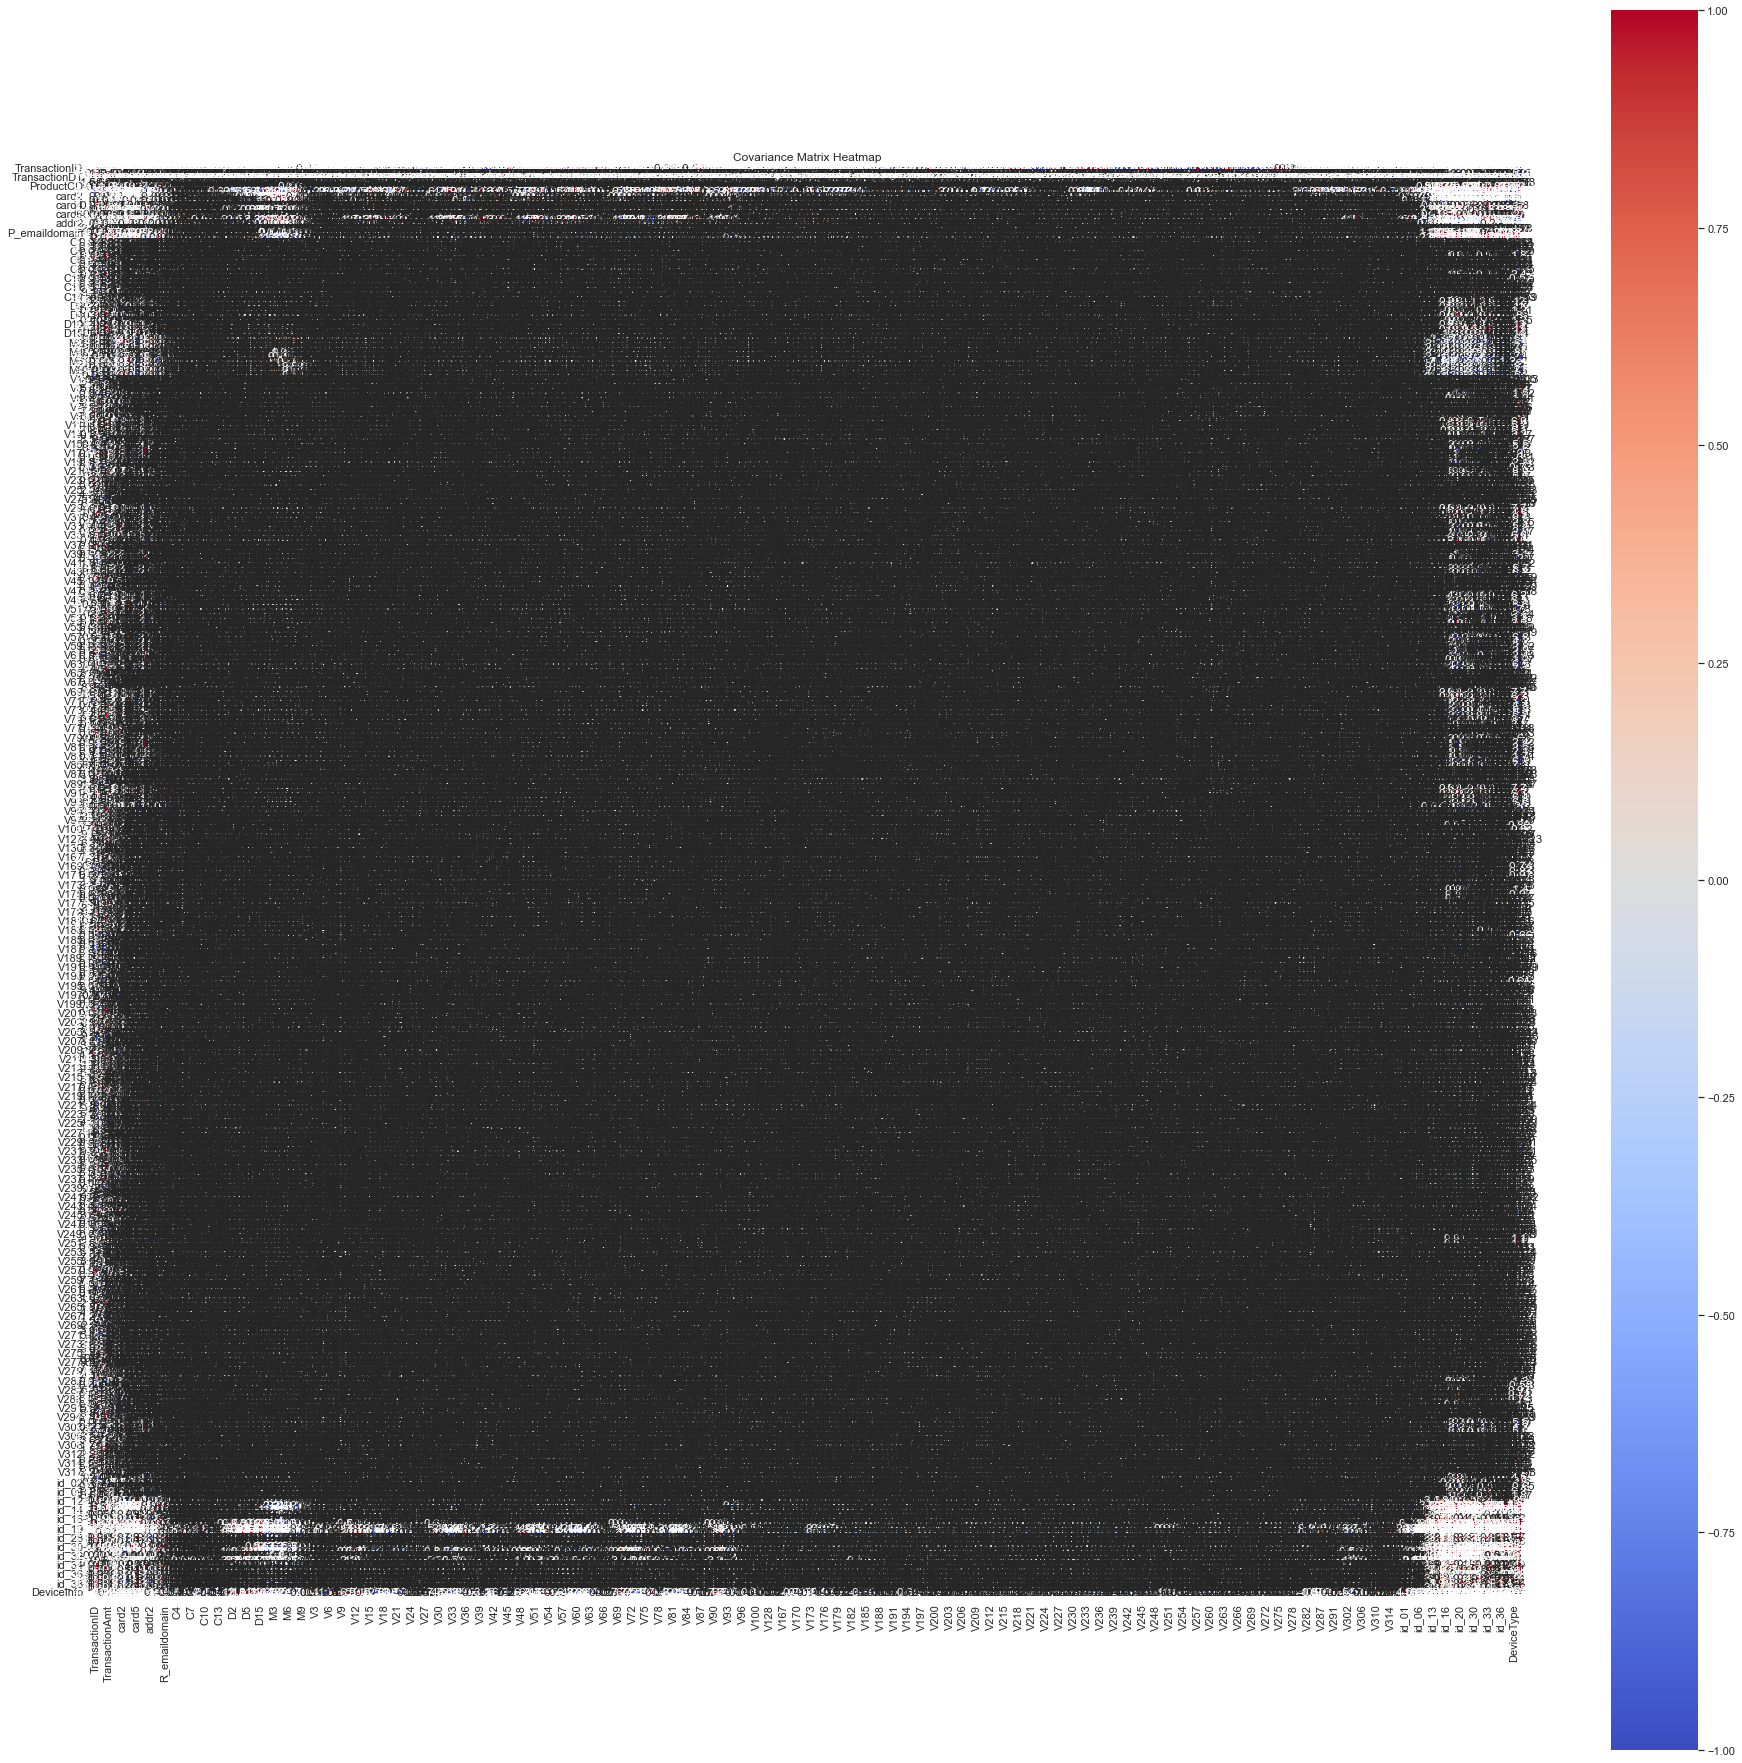

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the covariance matrix
cov_matrix = train.cov()

# Create a white background heatmap of the covariance matrix
plt.figure(figsize=(32, 32))
sns.set(style="white")  

ax = sns.heatmap(
    cov_matrix,
    annot=True,         # Display the covariance values on the heatmap
    cmap="coolwarm",    # Color map for the heatmap
    square=True,        # Make the heatmap square
    vmin=-1, vmax=1,    # Set the color scale limits
    linewidths=0.5,     # Line width between cells
)

plt.title("Covariance Matrix Heatmap")
plt.show()

The approach i took to address imbalanced dataset is undersampling or oversampling with SMOTE

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def undersample(train):
  # Assuming your DataFrame is named df and the target column is "isFraud"
  fraud_counts = train['isFraud'].value_counts()

  # Visualize the class imbalance
  plt.bar(fraud_counts.index, fraud_counts.values)
  plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
  plt.ylabel('Frequency')
  plt.title('Class Distribution')
  plt.show()

  # Perform undersampling
  fraud = train[train['isFraud'] == 1]
  not_fraud = train[train['isFraud'] == 0]

  # Reduce the number of "not fraud" samples to match the number of "fraud" samples
  not_fraud_undersampled = not_fraud.sample(len(fraud))

  # Concatenate the fraud and undersampled not_fraud dataframes
  df_undersampled = pd.concat([fraud, not_fraud_undersampled])

  # Shuffle the undersampled dataframe
  df_undersampled = shuffle(df_undersampled)

  # Visualize the new class distribution after undersampling
  undersampled_counts = df_undersampled['isFraud'].value_counts()
  plt.bar(undersampled_counts.index, undersampled_counts.values)
  plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
  plt.ylabel('Frequency')
  plt.title('Class Distribution after Undersampling')
  plt.show()

  return df_undersampled

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

def oversample(train):
    # Assuming your DataFrame is named train and the target column is "isFraud"
    fraud_counts = train['isFraud'].value_counts()

    # Visualize the class imbalance
    plt.bar(fraud_counts.index, fraud_counts.values)
    plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()

    # Perform oversampling
    smote = SMOTE(random_state=42)
    X = train.drop('isFraud', axis=1)
    y = train['isFraud']
    X_oversampled, y_oversampled = smote.fit_resample(X, y)

    # Combine the oversampled features and labels into a single dataframe
    df_oversampled = pd.concat([X_oversampled, y_oversampled], axis=1)

    # Shuffle the oversampled dataframe
    df_oversampled = shuffle(df_oversampled)

    # Visualize the new class distribution after oversampling
    oversampled_counts = df_oversampled['isFraud'].value_counts()
    plt.bar(oversampled_counts.index, oversampled_counts.values)
    plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
    plt.ylabel('Frequency')
    plt.title('Class Distribution after Oversampling')
    plt.show()

    return df_oversampled

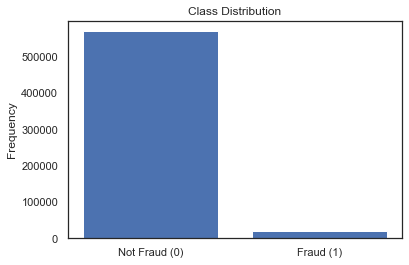

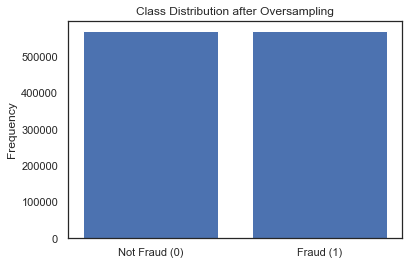

In [44]:
new_train = pd.DataFrame() 

if CHOSEN_CONFIG["sampling"] == "undersample":
  new_train = undersample(train)
if CHOSEN_CONFIG["sampling"] == "oversample":
  new_train = oversample(train)
if CHOSEN_CONFIG["sampling"] == "normal":
  new_train = train
  
# New train and test DF for model training and validation
train_X = new_train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
train_y = new_train['isFraud']
test_X = test.drop(['TransactionDT'], axis=1)

In [45]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets
# 70/30 standard train test split
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=42)


## Model Training and Evaluation

In [46]:
# Define F1 score metric
def f1_score(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

### LightGBM

In [47]:

from sklearn.metrics import accuracy_score
from lightgbm.plotting import plot_importance
from matplotlib import pyplot

def test_lgb(train_X, train_y, val_X, val_y):
  
  # Parameters for lgb, explanation in each line
  lgb_params = {
                  'objective': 'binary', # Fraud or not fraud, binary classification problem
                  'max_depth': -1, # Maximum depth is set to infinite
                  "boosting_type": "gbdt", # Gradient boosted decision tree is the one im most familiar with 
                  "metric": 'auc', # Using area under curve for metric, optimal for binary classification, can also use binary_logloss
                  "verbosity": -1, # Logging all activities
                  "class_weight": "balanced" #To balance imbalanced class
              }
              
  # Create LightGBM dataset
  train_data = lgb.Dataset(train_X, label=train_y)
  val_data = lgb.Dataset(val_X, label=val_y, reference=train_data)

  # Train the model
  model = lgb.LGBMClassifier()
  model.set_params(**lgb_params)
  model.fit(train_X, train_y)

  # Make predictions on the test set
  y_pred=model.predict(val_X)

  # Evaluate model performance
  print("Classification Report:")
  print(classification_report(val_y, y_pred))
  print("ROC AUC Score:", roc_auc_score(val_y, y_pred))

  accuracy=accuracy_score(y_pred, val_y)
  print(f'accuracy got: {accuracy}')

  # Plot the feature importance with a white background color
  fig, ax = plt.subplots()
  ax.set_facecolor('w')

  ax = plot_importance(model, ax=ax, max_num_features=20)
  fig.set_facecolor('w')
  pyplot.show()

  return model

### LogReg

In [48]:
from sklearn.linear_model import LogisticRegression


def test_logreg(train_X, train_y, val_X, val_y):

  # Train the logistic regression model
  lr = LogisticRegression(max_iter=1000)
  lr.fit(train_X, train_y)

  # Predict on test set
  y_pred = lr.predict(val_X)

  # Evaluate model performance
  print("Classification Report:")
  print(classification_report(val_y, y_pred))
  print("ROC AUC Score:", roc_auc_score(val_y, y_pred))

  return lr

### ANN

ANN Model for comparison, 
- uses sequential model of 128 -> 64 -> 32 relu dense layer, and 
- 1 sigmoid layer

Reasoning:
- Dense layers: The model uses three Dense layers with a decreasing number of neurons (128, 64, and 32). This architecture gradually refines the information and reduces the complexity of the representation. The ReLU activation function is used for these layers, as it is a popular choice for solving non-linear problems and mitigating the vanishing gradient problem.

- Dropout layers: To prevent overfitting, Dropout layers are added after each Dense layer. These layers randomly drop out neurons during training, helping to create a more robust model.

- Output layer: The output layer has a single neuron with a sigmoid activation function, which is used for binary classification tasks. This function outputs a probability value between 0 and 1, representing the likelihood of a transaction being fraudulent (1) or not fraudulent (0).

- Optimizer and loss function: The Adam optimizer is used for its adaptive learning rate and proven effectiveness in a wide range of tasks. The learning rate is set to 0.001, a common default value. The binary_crossentropy loss function is appropriate for binary classification tasks, as it measures the difference between the true labels and the predicted probabilities.

In [49]:
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def test_ann(train_X, train_y, val_X, val_y):
  # Define the model
  def create_model(input_dim):
      model = Sequential()
      model.add(Dense(128, input_dim=input_dim, activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(64, activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(32, activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(1, activation='sigmoid'))

      model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[f1_score])
      return model

  # Create the model
  input_dim = 308
  model = create_model(input_dim)

  history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(val_X, val_y))

  # Plot the training results
  def plot_history(history):
      plt.figure(figsize=(12, 4), facecolor='w')

      plt.subplot(1, 2, 1)
      plt.plot(history.history['loss'], label='Training Loss')
      plt.plot(history.history['val_loss'], label='Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.subplot(1, 2, 2)
      plt.plot(history.history['f1_score'], label='Training F1 Score')
      plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
      plt.xlabel('Epoch')
      plt.ylabel('F1 Score')
      plt.legend()
      plt.title('F1 Score over Time')

      plt.show()

  plot_history(history)

  
  # Make predictions on the test set
  y_pred=model.predict(val_X)
  
  y_pred = np.round(y_pred)

  # Evaluate model performance
  print("Classification Report:")
  print(classification_report(val_y, y_pred))
  print("ROC AUC Score:", roc_auc_score(val_y, y_pred))

  return model


### Final Output

Epoch 1/20
12467/12467 [==============================] - 49s 4ms/step - loss: 3.9196 - f1_score: 0.4584 - val_loss: 0.6932 - val_f1_score: 0.0000e+00
Epoch 2/20
12467/12467 [==============================] - 48s 4ms/step - loss: 0.6924 - f1_score: 0.3704 - val_loss: 0.6625 - val_f1_score: 0.5722
Epoch 3/20
12467/12467 [==============================] - 43s 3ms/step - loss: 0.6412 - f1_score: 0.6016 - val_loss: 0.5705 - val_f1_score: 0.7040
Epoch 4/20
12467/12467 [==============================] - 44s 3ms/step - loss: 0.5155 - f1_score: 0.7490 - val_loss: 0.4349 - val_f1_score: 0.8013
Epoch 5/20
12467/12467 [==============================] - 46s 4ms/step - loss: 0.4482 - f1_score: 0.7876 - val_loss: 0.4050 - val_f1_score: 0.8218
Epoch 6/20
12467/12467 [==============================] - 49s 4ms/step - loss: 0.4108 - f1_score: 0.8061 - val_loss: 0.3730 - val_f1_score: 0.8045
Epoch 7/20
12467/12467 [==============================] - 47s 4ms/step - loss: 0.3840 - f1_score: 0.8215 - val_los

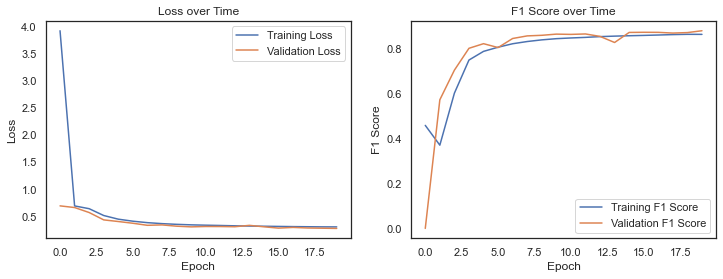

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88    170936
           1       0.89      0.87      0.88    170991

    accuracy                           0.88    341927
   macro avg       0.88      0.88      0.88    341927
weighted avg       0.88      0.88      0.88    341927

ROC AUC Score: 0.8827637665136439


,TransactionID,isFraud
0,3663549,0.059384
1,3663550,0.115413
2,3663551,0.345609
3,3663552,0.017582
4,3663553,0.041682


In [50]:
transaction_ids = test_X["TransactionID"]

model = None

if CHOSEN_CONFIG["model"] == "ann":
  model = test_ann(train_X, train_y, val_X, val_y)
elif CHOSEN_CONFIG["model"] == "logreg":
  model = test_logreg(train_X, train_y, val_X, val_y)
elif CHOSEN_CONFIG["model"] == "lgb":
  model = test_lgb(train_X, train_y, val_X, val_y)

predictions = model.predict(test_X.drop(columns={"TransactionID"}))

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=["prediction"])
predictions_df.rename(columns={'prediction' : 'isFraud'}, inplace=True)

# Merge DataFrames
merged_df = pd.concat([transaction_ids, predictions_df], axis=1)

# Save the predictions DataFrame as a CSV file
merged_df.to_csv("final_submission_telkomsel_ps2.csv", index=False)
merged_df.head(5)